# Introduction

I am following along with Chapter 4 of @fastbook2020.

## Download dataset

In [ ]:
from fastai.vision.all import *

In [ ]:
#collapse-output
path = untar_data(URLs.MNIST_SAMPLE)

So what got downloaded?

In [ ]:
path.ls()

(#3) [Path('/data/kaushik/.fastai/data/mnist_sample/valid'),Path('/data/kaushik/.fastai/data/mnist_sample/train'),Path('/data/kaushik/.fastai/data/mnist_sample/labels.csv')]

That huge path is a pain to look at so shorten it by setting the BASE_PATH.

In [ ]:
Path.BASE_PATH = path
path.ls()

(#3) [Path('valid'),Path('train'),Path('labels.csv')]

What do we have under train?

In [ ]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

What do we have under the 7?

In [ ]:
(path/'train'/'7').ls().sorted()

(#6265) [Path('train/7/10002.png'),Path('train/7/1001.png'),Path('train/7/10014.png'),Path('train/7/10019.png'),Path('train/7/10039.png'),Path('train/7/10046.png'),Path('train/7/10050.png'),Path('train/7/10063.png'),Path('train/7/10077.png'),Path('train/7/10086.png')...]

We have 6,265 images of sevens. Look at one using the PIL library.

In [ ]:
Image.open((path/'train'/'7').ls().sorted()[0])

In [ ]:
seven_tensors = [tensor(Image.open(pic_path)).float()/255. for pic_path in (path/'train'/'7').ls().sorted()]
three_tensors = [tensor(Image.open(pic_path)).float()/255. for pic_path in (path/'train'/'3').ls().sorted()]
len(seven_tensors), len(three_tensors)

(6265, 6131)

Use Fastai convenience function _show\_image_ to display the tensor

<AxesSubplot:>

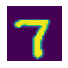

In [ ]:
show_image(seven_tensors[0])

In [ ]:
stacked_sevens = torch.stack(seven_tensors)
stacked_threes = torch.stack(three_tensors)
stacked_sevens.shape, stacked_threes.shape

(torch.Size([6265, 28, 28]), torch.Size([6131, 28, 28]))

# Assemble train and validation set

Assemble the training data. Each input will be a vector of 784 values.

In [ ]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1,28*28)
train_y = tensor([1]*len(three_tensors) + [0]*len(seven_tensors)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

Assemble the validation data

In [ ]:
valid_7_tensors = torch.stack([tensor(Image.open(pic_path)).float()/255. for pic_path in (path/'valid'/'7').ls().sorted()])
valid_3_tensors = torch.stack([tensor(Image.open(pic_path)).float()/255. for pic_path in (path/'valid'/'3').ls().sorted()])
valid_7_tensors.shape, valid_3_tensors.shape

(torch.Size([1028, 28, 28]), torch.Size([1010, 28, 28]))

In [ ]:
valid_x = torch.cat([valid_3_tensors, valid_7_tensors]).view(-1,28*28)
valid_y = tensor([1]*len(valid_3_tensors) + [0]*len(valid_7_tensors)).unsqueeze(1)
valid_x.shape, valid_y.shape

(torch.Size([2038, 784]), torch.Size([2038, 1]))

# Initialize Parameters

In [ ]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

We have one weight for each pixel in the image. We will also have a bias term.

In [ ]:
weights = init_params((28*28,1))
bias = init_params(1)
weights.shape, bias.shape

(torch.Size([784, 1]), torch.Size([1]))

# Get Predictions
Calculate the prediction for a single image

In [ ]:
(train_x[0]*weights.T).sum() + bias

tensor([3.9740], grad_fn=<AddBackward0>)

In [ ]:
train_x[0].shape, weights.shape, weights.T.shape, (train_x[0]*weights).shape

(torch.Size([784]),
 torch.Size([784, 1]),
 torch.Size([1, 784]),
 torch.Size([784, 784]))

In [ ]:
def linear1(xb): return xb @ weights + bias
preds = linear1(train_x)
preds

tensor([[ 3.9740],
        [-0.7695],
        [ 2.8669],
        ...,
        [-2.1245],
        [-6.0483],
        [-9.3377]], grad_fn=<AddBackward0>)

# Compute Loss

In [ ]:
def sigmoid(x): return 1./(1. + torch.exp(-x))

In [ ]:
def mnist_loss(predictions, targets):
    preds = predictions.sigmoid()
    return torch.where(targets==1, 1-preds, preds).mean()

In [ ]:
mnist_loss(preds, train_y)

tensor(0.3764, grad_fn=<MeanBackward0>)

# Mini-Batches

In [ ]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

Each mini-batch is a tuple of some number of training examples and their corresponding labels

In [ ]:
dl = DataLoader(ds,batch_size=5,shuffle=True)
first(dl), list(dl)

((tensor([ 5, 20, 14, 11, 13]), ('f', 'u', 'o', 'l', 'n')),
 [(tensor([ 1, 13, 14,  7,  0]), ('b', 'n', 'o', 'h', 'a')),
  (tensor([ 8, 16,  4, 17, 19]), ('i', 'q', 'e', 'r', 't')),
  (tensor([11,  6,  2, 20, 15]), ('l', 'g', 'c', 'u', 'p')),
  (tensor([ 9, 18, 21, 12, 22]), ('j', 's', 'v', 'm', 'w')),
  (tensor([24, 25, 10,  3,  5]), ('y', 'z', 'k', 'd', 'f')),
  (tensor([23]), ('x',))])

In [ ]:
dset = list(zip(train_x, train_y))
dl = DataLoader(dset, batch_size=256)

valid_dset = list(zip(valid_x, valid_y))
valid_dl = DataLoader(valid_dset, batch_size=256)

Simulate a batch of training examples.

In [ ]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [ ]:
preds = linear1(batch)
preds

tensor([[ 3.9740],
        [-0.7695],
        [ 2.8669],
        [-6.0669]], grad_fn=<AddBackward0>)

In [ ]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.4383, grad_fn=<MeanBackward0>)

In [ ]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0103), tensor([-0.0719]))

# Gradient computation

In [ ]:
def calc_grad(xb,yb,model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

# Train

In [ ]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb,yb,model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

## Batch Accuracy

In [ ]:
def batch_accuracy(preds, yb):
    preds = preds.sigmoid() #note
    correct = (preds > 0.5).float() == yb
    return correct.float().mean()

In [ ]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.5000)

In [ ]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [ ]:
validate_epoch(linear1)

0.6533

Train one epoch

In [ ]:
lr = 1

weights = init_params((28*28,1))
bias = init_params(1)
params = weights, bias

train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6836

Train multiple epochs

In [ ]:
lr = 1

weights = init_params((28*28,1))
bias = init_params(1)
params = weights, bias

for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.6765 0.8387 0.8988 0.9267 0.9374 0.9462 0.954 0.9565 0.9599 0.9618 0.9638 0.9653 0.9667 0.9682 0.9682 0.9706 0.9711 0.9721 0.9721 0.9721 

# Refactor

## Replace gradient update with a home grown optimizer

In [ ]:
class BasicOptim(nn.Module):
    def __init__(self,params,lr): self.params, self.lr = list(params), lr
        
    def step(self,*args,**kwargs): 
        for p in self.params: p.data -= p.grad*self.lr
            
    def zero_grad(self,*args,**kwargs): 
        for p in self.params: p.grad = None

In [ ]:
lr = 1

weights = init_params((28*28,1))
bias = init_params(1)
params = weights, bias

opt = BasicOptim(params, lr)

def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb,yb,model)
        opt.step()
        opt.zero_grad()

for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.6269 0.8379 0.9174 0.9409 0.9496 0.9545 0.9589 0.9623 0.9658 0.9672 0.9687 0.9697 0.9692 0.9697 0.9721 0.9721 0.9721 0.9726 0.9726 0.9731 

## Replace init_params and linear1 with Pytorch nn.Linear

nn.Linear holds both the weights and bias and takes care of initializing the parameters.

In [ ]:
linear_model = nn.Linear(28*28,1)
weights, bias = linear_model.parameters()
weights.shape, bias.shape

(torch.Size([1, 784]), torch.Size([1]))

In [ ]:
lr = 1

linear_model = nn.Linear(28*28,1)
opt = BasicOptim(linear_model.parameters(), lr)

def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb,yb,model)
        opt.step()
        opt.zero_grad()

for i in range(20):
    train_epoch(linear_model, lr, params)
    print(validate_epoch(linear_model), end=' ')

0.4932 0.4932 0.6816 0.8687 0.9185 0.936 0.9502 0.958 0.9638 0.9658 0.9678 0.9697 0.9712 0.9741 0.9746 0.9761 0.9765 0.9775 0.9785 0.9785 

## Replace home grown optimizer with fastai SGD

In [ ]:
lr = 1

linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)

def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb,yb,model)
        opt.step()
        opt.zero_grad()

for i in range(20):
    train_epoch(linear_model, lr, params)
    print(validate_epoch(linear_model), end=' ')

0.4932 0.8447 0.8398 0.9126 0.9336 0.9478 0.9551 0.9629 0.9658 0.9678 0.9692 0.9717 0.9741 0.9751 0.9761 0.9761 0.977 0.978 0.9785 0.9785 

## Replace training loop with Fastai Learner.fit

Observe how we are able to pass in the mnist_loss and batch_accuracy functions. Recall that within these functions we pass the predictions through the sigmoid function.

In [ ]:
#collapse-output
dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, nn.Linear(28*28,1), loss_func=mnist_loss
                , opt_func=SGD
                , metrics = batch_accuracy)
learn.fit(20,lr=1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637023,0.503487,0.495584,00:00
1,0.524831,0.192524,0.839058,00:00
2,0.192777,0.178215,0.840039,00:00
3,0.084406,0.105942,0.912169,00:00
4,0.044523,0.077318,0.933268,00:00
5,0.028958,0.061924,0.947988,00:00
6,0.022560,0.052394,0.955839,00:00
7,0.019714,0.046067,0.962709,00:00
8,0.018272,0.041615,0.966143,00:00
9,0.017409,0.038327,0.967125,00:00


# Add a rectified linear unit

In [ ]:
#collapse-output
simple_net = nn.Sequential(nn.Linear(28*28,30), 
                           nn.ReLU(), 
                           nn.Linear(30,1))

learn = Learner(dls, simple_net, loss_func=mnist_loss
                  , opt_func=SGD
                  , metrics=batch_accuracy)


learn.fit(n_epoch=40, lr=0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.334276,0.397611,0.510304,00:00
1,0.153756,0.235990,0.795878,00:00
2,0.084339,0.117733,0.915113,00:00
3,0.054809,0.079118,0.940137,00:00
4,0.041189,0.061640,0.954367,00:00
5,0.034297,0.051851,0.963690,00:00
6,0.030381,0.045687,0.965653,00:00
7,0.027859,0.041476,0.966634,00:00
8,0.026048,0.038415,0.968106,00:00
9,0.024647,0.036075,0.969578,00:00


learn.recorder records the output from the training process. The three items recorded here are train_loss, valid_loss and batch_accuracy

In [ ]:
learn.recorder.values[:2]

[(#3) [0.334276407957077,0.39761149883270264,0.5103042125701904],
 (#3) [0.1537560522556305,0.2359904646873474,0.7958782911300659]]

Plot how the accuracy evolved during the training.

[<matplotlib.lines.Line2D>]

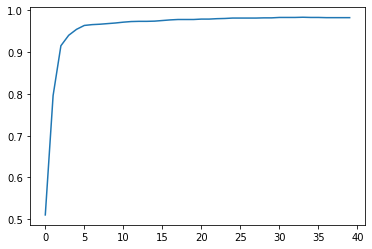

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2))

The final accuracy is as below:

In [ ]:
learn.recorder.values[-1][2]

0.98233562707901